In [14]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data_dir = "hubbard_dmrg_4"
exact_file = "hubbard_exact.hdf5"
l = 4
output_filename = f"hubbard_{l}_error_ut_6.pdf"
d_max = 30
d_min = 3

if l == 2:
    num_cnot = 22
elif l == 3:
    num_cnot = 191
elif l == 4:
    num_cnot = 472
else:
    raise ValueError(f"Invalid dimension {l}")

In [16]:
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [17]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = f_exact["energy"][()]
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is -1.7389083817406248.


In [18]:
# subspace_files = [f for f in all_files if "subspace" in f]
# for i in range(len(subspace_files)):
#     f_subspace = h5py.File(data_dir + "/" + subspace_files[i])
#     ref_energy = f_subspace["reference_energy"][()]
#     f_subspace.close()
#     print(f"Reference energy = {ref_energy}")

In [19]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact)
    df["steps"] = steps
    df["num_2q"] = steps * num_cnot
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps        energy  num_pos         error  steps  num_2q
i                                                                       
0    3  1.000000e-10 -1.373416e+00        3  3.654922e-01     50   23600
1    4  1.000000e-10 -1.649922e+00        4  8.898649e-02     50   23600
2    5  1.000000e-10 -1.718075e+00        5  2.083292e-02     50   23600
3    6  1.000000e-10 -1.737582e+00        6  1.326173e-03     50   23600
4    7  1.000000e-10 -1.744572e+00        7  5.663571e-03     50   23600
..  ..           ...           ...      ...           ...    ...     ...
23  26  1.000000e-10 -6.254350e+07       26  6.254350e+07     10    4720
24  27  1.000000e-10 -1.140500e+08       27  1.140500e+08     10    4720
25  28  1.000000e-10 -1.968730e+08       28  1.968730e+08     10    4720
26  29  1.000000e-10 -2.913956e+08       29  2.913956e+08     10    4720
27  30  1.000000e-10 -4.131501e+08       30  4.131501e+08     10    4720

[308 rows x 7 columns]


In [20]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

     d           eps        energy  num_pos         error  steps  num_2q
i                                                                       
17  20  1.000000e-10 -3.017926e+06       20  3.017925e+06     50   23600
18  21  1.000000e-10 -6.035248e+06       21  6.035246e+06     50   23600
19  22  1.000000e-10 -1.094415e+07       22  1.094415e+07     50   23600
20  23  1.000000e-10 -1.640188e+07       23  1.640188e+07     50   23600
21  24  1.000000e-10 -2.695707e+07       24  2.695707e+07     50   23600
..  ..           ...           ...      ...           ...    ...     ...
23  26  1.000000e-10 -6.254350e+07       26  6.254350e+07     10    4720
24  27  1.000000e-10 -1.140500e+08       27  1.140500e+08     10    4720
25  28  1.000000e-10 -1.968730e+08       28  1.968730e+08     10    4720
26  29  1.000000e-10 -2.913956e+08       29  2.913956e+08     10    4720
27  30  1.000000e-10 -4.131501e+08       30  4.131501e+08     10    4720

[121 rows x 7 columns]


In [21]:
df_inter = df_total[df_total["d"] <= d_max]
df_small = df_inter[df_inter["d"] >= d_min]
print(df_small.head())

   d           eps    energy  num_pos     error  steps  num_2q
i                                                             
0  3  1.000000e-10 -1.373416        3  0.365492     50   23600
1  4  1.000000e-10 -1.649922        4  0.088986     50   23600
2  5  1.000000e-10 -1.718075        5  0.020833     50   23600
3  6  1.000000e-10 -1.737582        6  0.001326     50   23600
4  7  1.000000e-10 -1.744572        7  0.005664     50   23600


In [22]:
chemical_accuracy = 0.00159 * l ** 2
print(f"Chemical accuracy is {chemical_accuracy} ha.")

Chemical accuracy is 0.02544 ha.


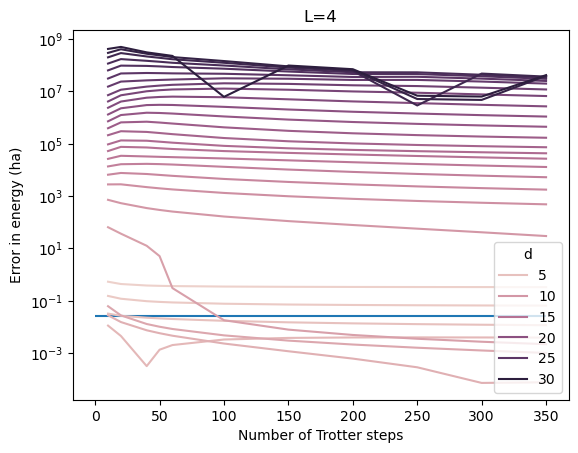

In [23]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.hlines(chemical_accuracy, 0, 350)
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
# plt.ylim(top=chemical_accuracy+ 0.01)
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Error in energy (ha)")
plt.title(f"L={l}")
plt.savefig(output_filename)

In [24]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [25]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.3266466322092101 0.525132926879821
4 0.06419860481407413 0.15042051308377635
5 0.011450562713260393 0.03171209845447098
6 0.00031265304098537783 0.011062755922515377
7 7.132394248321461e-05 0.027459100978365125
8 0.000996353241263348 0.06088718882347477
9 0.002151467442911059 63.51152616192564
10 29.227697153460586 707.0105485965148
11 476.14007367478223 2768.6744555488594
12 1736.565523048981 7516.250284824885
13 5169.150278114136 16759.835047042463
14 12714.202854433266 34065.96457550276
15 26410.37840830874 74672.44580618145
16 42479.16484200486 131728.94681949553


In [26]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_6052/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.3266466322092101 and 0.525132926879821